In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
# from NS_model_tf import Sampler, Navier_Stokes2D
import os
os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

import scipy
import scipy.io
import time

import sys

import sys

import scipy
import scipy.io
import time


import logging

import os.path
import shutil
from datetime import datetime
import pickle
def U_gamma_1(x):
    num = x.shape[0]
    return np.tile(np.array([1.0, 0.0]), (num, 1))


def U_gamma_2(x):
    num = x.shape[0]
    return np.zeros((num, 2))


def f(x):
    num = x.shape[0]
    return np.zeros((num, 2))

def operator(psi, p, x, y, Re, sigma_x=1.0, sigma_y=1.0):
    u = tf.gradients(psi, y)[0] / sigma_y
    v = - tf.gradients(psi, x)[0] / sigma_x

    u_x = tf.gradients(u, x)[0] / sigma_x
    u_y = tf.gradients(u, y)[0] / sigma_y

    v_x = tf.gradients(v, x)[0] / sigma_x
    v_y = tf.gradients(v, y)[0] / sigma_y

    p_x = tf.gradients(p, x)[0] / sigma_x
    p_y = tf.gradients(p, y)[0] / sigma_y

    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    u_yy = tf.gradients(u_y, y)[0] / sigma_y

    v_xx = tf.gradients(v_x, x)[0] / sigma_x
    v_yy = tf.gradients(v_y, y)[0] / sigma_y

    Ru_momentum = u * u_x + v * u_y + p_x - (u_xx + u_yy) / Re
    Rv_momentum = u * v_x + v * v_y + p_y - (v_xx + v_yy) / Re

    return Ru_momentum, Rv_momentum




In [2]:

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

class Navier_Stokes2D:
    def __init__(self, layers, operator, bcs_sampler, res_sampler, Re, mode , sess):


        self.mode = mode

        self.dirname, logpath = self.make_output_dir()
        self.logger = self.get_logger(logpath)     

        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_y, self.sigma_y = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler


        # Navier Stokes constant
        self.Re = tf.constant(Re, dtype=tf.float32)

        # Adaptive re-weighting constant
        self.beta = 0.9
        self.adaptive_constant_bcs_val = np.array(1.0)

        # Define Tensorflow session
        self.sess = sess

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)


        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.adaptive_constant_bcs_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs_val.shape)

        # Evaluate predictions
        self.u_bc1_pred, self.v_bc1_pred = self.net_uv(self.x_bc1_tf, self.y_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred = self.net_uv(self.x_bc2_tf, self.y_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred = self.net_uv(self.x_bc3_tf, self.y_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred = self.net_uv(self.x_bc4_tf, self.y_bc4_tf)

        self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.psi_pred, self.p_pred = self.net_psi_p(self.x_u_tf, self.y_u_tf)
        self.u_pred, self.v_pred = self.net_uv(self.x_u_tf, self.y_u_tf)
        self.u_momentum_pred, self.v_momentum_pred = self.net_r(self.x_r_tf, self.y_r_tf)

        # Residual loss
        self.loss_u_momentum = tf.reduce_mean(tf.square(self.u_momentum_pred))
        self.loss_v_momentum = tf.reduce_mean(tf.square(self.v_momentum_pred))

        self.loss_res = self.loss_u_momentum + self.loss_v_momentum
        
        # Boundary loss
        self.loss_bc1 = tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.U_bc2_pred))
        self.loss_bc3 = tf.reduce_mean(tf.square(self.U_bc3_pred))
        self.loss_bc4 = tf.reduce_mean(tf.square(self.U_bc4_pred))
        
        self.loss_bcs = self.adaptive_constant_bcs_tf * tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf) +tf.square(self.U_bc2_pred) + tf.square(self.U_bc3_pred) + tf.square(self.U_bc4_pred))
        
        # Total loss
        self.loss = self.loss_res + self.loss_bcs

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        self.loss_tensor_list = [self.loss ,  self.loss_res,  self.loss_bc1 , self.loss_bc2 , self.loss_bc3, self.loss_bc4] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bc1", "loss_bc2", "loss_bc3", "loss_bc4"] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)
        # Logger
        self.loss_res_log = []
        self.loss_bcs_log = []
        # self.saver = tf.train.Saver()

        # Generate dicts for gradients storage
        self.dict_gradients_res_layers = self.generate_grad_dict()
        self.dict_gradients_bcs_layers = self.generate_grad_dict()

        # Gradients Storage
        self.grad_res = []
        self.grad_bcs = []
        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(self.loss_bcs, self.weights[i])[0])

        self.adpative_constant_bcs_list = []
        self.adpative_constant_res_list = []
        self.adpative_constant_bcs_log = []

        for i in range(len(self.layers) - 1):
            self.adpative_constant_res_list.append( tf.reduce_max(tf.abs(self.grad_res[i])))
            self.adpative_constant_bcs_list.append(  tf.reduce_mean(tf.abs(self.grad_bcs[i])))

        self.adaptive_constant_bcs = tf.reduce_max(tf.stack(self.adpative_constant_res_list))/  tf.reduce_mean(tf.stack(self.adpative_constant_bcs_list))




        self.loss_tensor_list = [self.loss ,  self.loss_res,  self.loss_bc1 ,  self.loss_bc2 ,  self.loss_bc3  ,  self.loss_bc4] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bcs1" , "loss_bcs2", "loss_bcs3" ,  "loss_bcs4"] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)

        init = tf.global_variables_initializer()
        self.sess.run(init)
        

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H


    # Forward pass for stream-pressure formulation
    def net_psi_p(self, x, y):
        psi_p = self.forward_pass(tf.concat([x, y], 1))
        psi = psi_p[:, 0:1]
        p = psi_p[:, 1:2]
        return psi, p

    # Forward pass for velocities
    def net_uv(self, x, y):
        psi, p = self.net_psi_p(x, y)
        u = tf.gradients(psi, y)[0] / self.sigma_y
        v = - tf.gradients(psi, x)[0] / self.sigma_x
        return u, v

    # Forward pass for residual
    def net_r(self, x, y):
        psi, p = self.net_psi_p(x, y)
        u_momentum_pred, v_momentum_pred = self.operator(psi, p, x, y,
                                                         self.Re,
                                                         self.sigma_x, self.sigma_y)

        return u_momentum_pred, v_momentum_pred

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter ,  bcbatch_size , ubatch_size):

        start_time = timeit.default_timer()
        # Fetch boundary mini-batches
        batch_size = bcbatch_size
        X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
        X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
        X_bc3_batch, _ = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
        X_bc4_batch, _ = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

        # Fetch residual mini-batch
        batch_size = ubatch_size

        X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

        # Define a dictionary for associating placeholders with data
        tf_dict = {self.x_bc1_tf: X_bc1_batch[:, 0:1], self.y_bc1_tf: X_bc1_batch[:, 1:2],
                    self.U_bc1_tf: u_bc1_batch,
                    self.x_bc2_tf: X_bc2_batch[:, 0:1], self.y_bc2_tf: X_bc2_batch[:, 1:2],
                    self.x_bc3_tf: X_bc3_batch[:, 0:1], self.y_bc3_tf: X_bc3_batch[:, 1:2],
                    self.x_bc4_tf: X_bc4_batch[:, 0:1], self.y_bc4_tf: X_bc4_batch[:, 1:2],
                    self.x_r_tf: X_res_batch[:, 0:1], self.y_r_tf: X_res_batch[:, 1:2],
                    self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val
                    }
        for it in range(nIter):

            # Run the Tensorflow session to minimize the loss
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value, loss_r_value = self.sess.run([self.loss_bcs, self.loss_res], tf_dict)

                # Compute the adaptive constant
                adaptive_constant_bcs_val = self.sess.run(self.adaptive_constant_bcs, tf_dict)

                self.adaptive_constant_bcs_val = adaptive_constant_bcs_val *  (1.0 - self.beta) + self.beta * self.adaptive_constant_bcs_val

                # self.adpative_constant_bcs_log.append(self.adaptive_constant_bcs_val)
                # self.loss_bcs_log.append(loss_u_value)
                # self.loss_res_log.append(loss_r_value)

                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' % (it, loss_value, loss_u_value, loss_r_value, elapsed))

                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                start_time = timeit.default_timer()

            sys.stdout.flush()
            start_time = timeit.default_timer()

            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])
            # # Store gradients
            # if it % 10000 == 0:
            #     self.save_gradients(tf_dict)
            #     print("Gradients information stored ...")

   # Trains the model by minimizing the MSE loss
    def trainmb(self, nIter, batch_size):
        itValues = [1,100,1000,39999]

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, _ = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            X_bc4_batch, _ = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_bc1_tf: X_bc1_batch[:, 0:1], self.y_bc1_tf: X_bc1_batch[:, 1:2],
                       self.U_bc1_tf: u_bc1_batch,
                       self.x_bc2_tf: X_bc2_batch[:, 0:1], self.y_bc2_tf: X_bc2_batch[:, 1:2],
                       self.x_bc3_tf: X_bc3_batch[:, 0:1], self.y_bc3_tf: X_bc3_batch[:, 1:2],
                       self.x_bc4_tf: X_bc4_batch[:, 0:1], self.y_bc4_tf: X_bc4_batch[:, 1:2],
                       self.x_r_tf: X_res_batch[:, 0:1], self.y_r_tf: X_res_batch[:, 1:2],
                       self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val
                       }

            # Run the Tensorflow session to minimize the loss
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value, loss_r_value = self.sess.run([self.loss_bcs, self.loss_res], tf_dict)
                self.print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' % (it, loss_value, loss_u_value, loss_r_value, elapsed))

                if it % 10 == 0:

                    # Compute the adaptive constant
                    adaptive_constant_bcs_val = self.sess.run(self.adaptive_constant_bcs, tf_dict)

                    self.adaptive_constant_bcs_val = adaptive_constant_bcs_val *  (1.0 - self.beta) + self.beta * self.adaptive_constant_bcs_val

                    self.adpative_constant_bcs_log.append(self.adaptive_constant_bcs_val)
                    # self.loss_bcs_log.append(loss_u_value)
                    # self.loss_res_log.append(loss_r_value)


                    self.print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))

  
            sys.stdout.flush()

            start_time = timeit.default_timer()
            if it in itValues:
                    self.plot_layerLoss(tf_dict , it)
                    self.print("Gradients information stored ...")

            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])


    # Evaluates predictions at test points
    def predict_psi_p(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.y_u_tf: X_star[:, 1:2]}
        psi_star = self.sess.run(self.psi_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        return psi_star, p_star

    def predict_uv(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.y_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        return u_star, v_star



 ############################################################

    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values

    def plot_loss_history(self ):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.show()
    ############################################################
  
  # ###############################################################################################################################################
   # 
   #  
    def plot_layerLoss(self , tf_dict , epoch):
        ## Gradients #
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res, grad_bc1    = self.sess.run([ self.grad_res[i],self.grad_bcs[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bc1.flatten())

        num_hidden_layers = num_layers -1
        cnt = 1
        fig = plt.figure(4, figsize=(13, 4))
        for j in range(num_hidden_layers):
            ax = plt.subplot(1, num_hidden_layers, cnt)
            ax.set_title('Layer {}'.format(j + 1))
            ax.set_yscale('symlog')
            gradients_res = self.dict_gradients_res_layers['layer_' + str(j + 1)][-1]
            gradients_bc1 = self.dict_gradients_bcs_layers['layer_' + str(j + 1)][-1]

            sns.distplot(gradients_res, hist=False,kde_kws={"shade": False},norm_hist=True,  label=r'$\nabla_\theta \mathcal{L}_r$')

            sns.distplot(gradients_bc1, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc1}}$')

            #ax.get_legend().remove()
            ax.set_xlim([-1.0, 1.0])
            #ax.set_ylim([0, 150])
            cnt += 1
        handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc="center",  bbox_to_anchor=(0.5, -0.03),borderaxespad=0,bbox_transform=fig.transFigure, ncol=3)
        text = 'layerLoss_epoch' + str(epoch) +'.png'
        plt.savefig(os.path.join(self.dirname,text) , bbox_inches='tight')
        plt.close("all")
    # #########################
    # def make_output_dir(self):
        
    #     if not os.path.exists("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints"):
    #         os.mkdir("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints")
    #     dirname = os.path.join("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
    #     os.mkdir(dirname)
    #     text = 'output.log'
    #     logpath = os.path.join(dirname, text)
    #     shutil.copyfile('/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/M2.py', os.path.join(dirname, 'M2.py'))

    #     return dirname, logpath
    
    # # ###########################################################
    def make_output_dir(self):
        
        if not os.path.exists("checkpoints"):
            os.mkdir("checkpoints")
        dirname = os.path.join("checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
        os.mkdir(dirname)
        text = 'output.log'
        logpath = os.path.join(dirname, text)
        shutil.copyfile('M2.ipynb', os.path.join(dirname, 'M2.ipynb'))
        return dirname, logpath
    

    def get_logger(self, logpath):
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)
        sh = logging.StreamHandler()
        sh.setLevel(logging.DEBUG)        
        sh.setFormatter(logging.Formatter('%(message)s'))
        fh = logging.FileHandler(logpath)
        logger.addHandler(sh)
        logger.addHandler(fh)
        return logger


   
    def print(self, *args):
        for word in args:
            if len(args) == 1:
                self.logger.info(word)
            elif word != args[-1]:
                for handler in self.logger.handlers:
                    handler.terminator = ""
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32: 
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)
            else:
                for handler in self.logger.handlers:
                    handler.terminator = "\n"
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32:
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)


    def plot_loss_history(self , path):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            self.print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.savefig(path)
        plt.close("all" , )
       #######################
    def save_NN(self):

        uv_weights = self.sess.run(self.weights)
        uv_biases = self.sess.run(self.biases)

        with open(os.path.join(self.dirname,'model.pickle'), 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            self.print("Save uv NN parameters successfully in %s ..." , self.dirname)

        # with open(os.path.join(self.dirname,'loss_history_BFS.pickle'), 'wb') as f:
        #     pickle.dump(self.loss_rec, f)
        with open(os.path.join(self.dirname,'loss_history_BFS.png'), 'wb') as f:
            self.plot_loss_history(f)


    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values


    def generate_grad_dict(self):
        num = len(self.layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict
    
    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values
            
    def plt_prediction(self , x1 , x2 , X_star , u_star , u_pred , f_star , f_pred):
        from mpl_toolkits.axes_grid1 import ImageGrid

        ### Plot ###

        # Exact solution & Predicted solution
        # Exact soluton
        U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
        F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

        # Predicted solution
        U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
        F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

        titles = ['Exact $u(x)$' , 'Predicted $u(x)$' , 'Absolute error' , 'Exact $v(x)$' , 'Predicted $v(x)$' , 'Absolute error']
        data = [U_star.T , U_pred ,  np.abs(U_star.T - U_pred) , F_star.T , F_pred ,  np.abs(F_star.T - F_pred) ]

        fig_1 = plt.figure(1, figsize=(13, 5))
        grid = ImageGrid(fig_1, 111, direction="row", nrows_ncols=(2,3), 
                        label_mode="1", axes_pad=1.7, share_all=False, 
                        cbar_mode="each", cbar_location="right", 
                        cbar_size="5%", cbar_pad=0.0)
    # CREATE ARGUMENTS DICT FOR CONTOURPLOTS
        minmax_list = []
        for d in data:
            # if(local):
            #     minmax_list.append([np.min(d), np.max(d)])
            # else:
            minmax_list.append([np.min(d), np.max(d)])

            # kwargs_list.append(dict(levels=np.linspace(minmax_list[-1][0],minmax_list[-1][1], 60), cmap="coolwarm", vmin=minmax_list[-1][0], vmax=minmax_list[-1][1]))

        for ax, z, minmax, title in zip(grid, data, minmax_list, titles):
        #pcf = [ax.tricontourf(x, y, z[0,:], **kwargs)]
            #pcfsets.append(pcf)
            # if (timeStp == 0):
            pcf = [ax.pcolor(x1, x2, z , cmap='jet')]
            cb = ax.cax.colorbar(pcf[0], ticks=np.linspace(minmax[0],minmax[1],7),  format='%.3e')
            ax.cax.tick_params(labelsize=14.5)
            ax.set_title(title, fontsize=14.5, pad=7)
            ax.set_ylabel("y", labelpad=14.5, fontsize=14.5, rotation="horizontal")
            ax.set_xlabel("x", fontsize=14.5)
            ax.tick_params(labelsize=14.5)
            ax.set_xlim(x1.min(), x1.max())
            ax.set_ylim(x2.min(), x2.max())
            ax.set_aspect("equal")

        fig_1.set_size_inches(15, 10, True)
        fig_1.subplots_adjust(left=0.7, bottom=0, right=2.2, top=0.5, wspace=None, hspace=None)
        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"prediction.png"), dpi=300 , bbox_inches='tight')
        plt.close("all" , )


    def plot_grad(self ):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        ax.semilogy(self.adpative_constant_bcs_log, label=r'$\bar{\nabla_\theta \mathcal{L}_{u_{bc}}}$')
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        path = os.path.join(self.dirname,'grad_history.png')
        plt.savefig(path)
        plt.close("all" , )



In [3]:
#        [elapsed, error_u , error_v ,  error_p] = test_method(mtd , layers, operator, bcs_sampler, res_sampler ,Re , stiff_ratio ,  X_star , X , Y)

def test_method(method , layers, operator, bcs_sampler, res_sampler, Re ,  mode , X_star , X , Y , nIter ,mbbatch_size , bcbatch_size , ubatch_size ):


    model = Navier_Stokes2D(layers, operator, bcs_sampler, res_sampler, Re, mode)

    # Train model
    start_time = time.time()

    if method =="full_batch":
        model.train(nIter  , bcbatch_size , ubatch_size  )
    elif method =="mini_batch":
        model.trainmb(nIter, mbbatch_size)
    else:
        print("unknown method!")
    elapsed = time.time() - start_time

    # Predictions
    _, p_pred = model.predict_psi_p(X_star)
    u_pred, v_pred = model.predict_uv(X_star)

    # psi_star = griddata(X_star, psi_pred.flatten(), (X, Y), method='cubic')
    p_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
    # u_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    # v_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')

    # velocity = np.sqrt(u_pred**2 + v_pred**2)
    # velocity_star = griddata(X_star, velocity.flatten(), (X, Y), method='cubic')

    # Reference
    u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
    v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
    # velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

    u_pred = u_pred.reshape(100,100)
    v_pred = v_pred.reshape(100,100)
    p_pred = p_pred.reshape(100,100)

    # Relative error
    error_u = np.linalg.norm(u_ref - u_pred.T, 2) / np.linalg.norm(u_ref, 2)
    print('l2 error: {:.2e}'.format(error_u))
    error_v = np.linalg.norm(v_ref - v_pred.T, 2) / np.linalg.norm(v_ref, 2)
    print('l2 error: {:.2e}'.format(error_v))
    error_p = np.linalg.norm(p_pred - p_star.T, 2) / np.linalg.norm(p_star, 2)
    print('l2 error: {:.2e}'.format(error_p))

    return [elapsed, error_u , error_v ,error_p ]



Method:  mini_batch
Epoch:  1








2023-12-12 06:19:50.420350: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 06:19:50.442648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-12-12 06:19:50.443132: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558d163819e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-12 06:19:50.443145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-12 06:19:50.443660: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


It: 0, Loss: 9.572e-01, Loss_u: 8.112e-01, Loss_r: 1.459e-01, Time: 15.32
constant_bcs_val: 1.612
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a dep

ValueError: not enough values to unpack (expected 2, got 1)

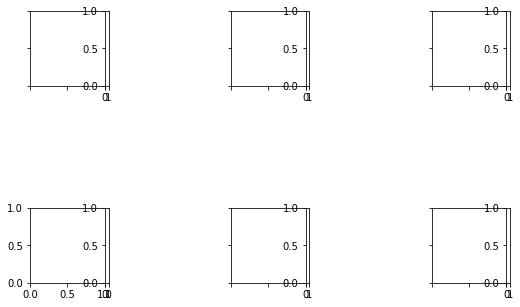

In [4]:



nIter =401
bcbatch_size = 350
ubatch_size = 5000
mbbatch_size = 128

# Parameters of equations
Re = 100.0

# Domain boundaries
bc1_coords = np.array([[0.0, 1.0], [1.0, 1.0]])
bc2_coords = np.array([[0.0, 0.0], [0.0, 1.0]])
bc3_coords = np.array([[1.0, 0.0], [1.0, 1.0]])
bc4_coords = np.array([[0.0, 0.0], [1.0, 0.0]])
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])

# Define model
mode = 'M2'
layers = [2, 50, 50, 50, 50 , 50 , 2]

stiff_ratio = False  # Log the eigenvalues of Hessian of losses


# Test Data
nx = 100
ny = 100  # change to 100
x = np.linspace(0.0, 1.0, nx)
y = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(x, y)


X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))


iterations = 1
methods = ["mini_batch" ]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_v_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create boundary conditions samplers
        bc1 = Sampler(2, bc1_coords, lambda x: U_gamma_1(x), name='Dirichlet BC1')
        bc2 = Sampler(2, bc2_coords, lambda x: U_gamma_2(x), name='Dirichlet BC2')
        bc3 = Sampler(2, bc3_coords, lambda x: U_gamma_2(x), name='Dirichlet BC3')
        bc4 = Sampler(2, bc4_coords, lambda x: U_gamma_2(x), name='Dirichlet BC4')
        bcs_sampler = [bc1, bc2, bc3, bc4]

        # Create residual sampler
        res_sampler = Sampler(2, dom_coords, lambda x: f(x), name='Forcing')

        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:

            mode = Navier_Stokes2D(layers, operator, bcs_sampler, res_sampler, Re, mode , sess)

            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                mode.train(nIter  , bcbatch_size , ubatch_size  )
            elif mtd =="mini_batch":
                mode.trainmb(nIter, mbbatch_size)
            else:
                mode.print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            _, p_pred = mode.predict_psi_p(X_star)
            u_pred, v_pred = mode.predict_uv(X_star)

            # Reference
            u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
            v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
            # velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

            u_pred = u_pred.reshape(100,100)
            v_pred = v_pred.reshape(100,100)

            # Relative error
            error_u = np.linalg.norm(u_ref - u_pred.T, 2) / np.linalg.norm(u_ref, 2)
            error_v = np.linalg.norm(v_ref - v_pred.T, 2) / np.linalg.norm(v_ref, 2)

            mode.print('l2 error: {:.2e}'.format(error_u))
            mode.print('l2 error: {:.2e}'.format(error_v))

       
            mode.print("average lambda_bc" , np.average(mode.adpative_constant_bcs_log))
            mode.print("average lambda_res" , str(1.0))
            # sess.close
            #             mode.plot_grad()
            mode.save_NN()
            mode.plt_prediction( X , Y , X_star , u_ref , u_pred , v_ref , v_pred)


        mode.print('elapsed: {:.2e}'.format(elapsed))
        mode.print('Relative L2 error_u: {:.2e}'.format(error_u))
        mode.print('Relative L2 error_v: {:.2e}'.format(error_v))

        time_list.append(elapsed)
        error_u_list.append(error_u)
        error_v_list.append(error_v)

    mode.print("\n\nMethod: ", mtd)
    mode.print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    mode.print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    mode.print("average of error_v_list:" , sum(error_v_list) / len(error_v_list) )

    result_dict[mtd] = [time_list ,error_u_list ,error_v_list ]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat(os.path.join(mode.dirname,""+mtd+"_Lid-driven-Cavity_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_exp"+str(bcbatch_size)+"nIter"+str(nIter)+".mat") , result_dict)




In [74]:
def plt_prediction(self , x1 , x2 , X_star , u_star , u_pred , f_star , f_pred):
    from mpl_toolkits.axes_grid1 import ImageGrid

    ### Plot ###

    # Exact solution & Predicted solution
    # Exact soluton
    U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
    F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

    # Predicted solution
    U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
    F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

    titles = ['Exact $u(x)$' , 'Predicted $u(x)$' , 'Absolute error' , 'Exact $v(x)$' , 'Predicted $v(x)$' , 'Absolute error']
    data = [U_star.T , U_pred ,  np.abs(U_star.T - U_pred) , F_star.T , F_pred ,  np.abs(F_star.T - F_pred) ]

    fig_1 = plt.figure(1, figsize=(13, 5))
    grid = ImageGrid(fig_1, 111, direction="row", nrows_ncols=(2,3), 
                    label_mode="1", axes_pad=1.7, share_all=False, 
                    cbar_mode="each", cbar_location="right", 
                    cbar_size="5%", cbar_pad=0.0)
# CREATE ARGUMENTS DICT FOR CONTOURPLOTS
    minmax_list = []
    for d in data:
        # if(local):
        #     minmax_list.append([np.min(d), np.max(d)])
        # else:
        minmax_list.append([np.min(d), np.max(d)])

        # kwargs_list.append(dict(levels=np.linspace(minmax_list[-1][0],minmax_list[-1][1], 60), cmap="coolwarm", vmin=minmax_list[-1][0], vmax=minmax_list[-1][1]))

    for ax, z, minmax, title in zip(grid, data, minmax_list, titles):
    #pcf = [ax.tricontourf(x, y, z[0,:], **kwargs)]
        #pcfsets.append(pcf)
        # if (timeStp == 0):
        pcf = [ax.pcolor(x1, x2, z , cmap='jet')]
        cb = ax.cax.colorbar(pcf[0], ticks=np.linspace(minmax[0],minmax[1],7),  format='%.3e')
        ax.cax.tick_params(labelsize=14.5)
        ax.set_title(title, fontsize=14.5, pad=7)
        ax.set_ylabel("y", labelpad=14.5, fontsize=14.5, rotation="horizontal")
        ax.set_xlabel("x", fontsize=14.5)
        ax.tick_params(labelsize=14.5)
        ax.set_xlim(x1.min(), x1.max())
        ax.set_ylim(x2.min(), x2.max())
        ax.set_aspect("equal")

    fig_1.set_size_inches(15, 10, True)
    fig_1.subplots_adjust(left=0.7, bottom=0, right=2.2, top=0.5, wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(os.path.join(self.dirname,"prediction.png"), dpi=300 , bbox_inches='tight')
    plt.close("all" , )


In [70]:
u_ref.flatten()[:,None].shape

(10000, 1)

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


In [13]:
v_pred.shape

(100, 100)

In [ ]:

import scipy.io

mode = 'M2'
mbbatch_size = 128
ubatch_size = 5000
bcbatch_size = 500
iterations = 40000

time_list = []
error_u_list = []
error_v_list = []
error_p_list = []
    
methods = ["mini_batch" , "full_batch"]
result_dict =  dict((mtd, []) for mtd in methods)

##Mini Batch
time_list = [1831.07 , ]
error_u_list = [0.2112 , 0.]
error_v_list = [0.3271 , 0.]
error_p_list = [0.094 , 0.]

for mtd in methods:
    result_dict[mtd] = [time_list ,error_u_list ,error_v_list ,  error_p_list]


##Full Batch
time_list = [8048.86 , ]
error_u_list = [ 0.0367 ,0. ]
error_v_list = [0.0706 , 0.]
error_p_list = [0.465 , 0.]

for mtd in methods:
    result_dict[mtd] = [time_list ,error_u_list ,error_v_list ,  error_p_list]


scipy.io.savemat("./dataset/NS_model_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_"+str(bcbatch_size)+"_"+str(iterations)+".mat" , result_dict)


In [ ]:

### Plot ###
###########


In [ ]:


# Test Data
nx = 100
ny = 100  # change to 100
x = np.linspace(0.0, 1.0, nx)
y = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(x, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Predictions
psi_pred, p_pred = mode.predict_psi_p(X_star)
u_pred, v_pred = mode.predict_uv(X_star)

psi_star = griddata(X_star, psi_pred.flatten(), (X, Y), method='cubic')
p_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
u_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
v_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')

velocity = np.sqrt(u_pred**2 + v_pred**2)
velocity_star = griddata(X_star, velocity.flatten(), (X, Y), method='cubic')

# Reference
u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

# Relative error
error = np.linalg.norm(u_star - u_pred.T, 2) / np.linalg.norm(u_star, 2)
print('l2 error: {:.2e}'.format(error))
error = np.linalg.norm(v_star - v_pred.T, 2) / np.linalg.norm(v_star, 2)
print('l2 error: {:.2e}'.format(error))
error = np.linalg.norm(p_pred - p_star.T, 2) / np.linalg.norm(p_star, 2)
print('l2 error: {:.2e}'.format(error))

### Plot ###
###########


In [ ]:

# Reference solution & Prediceted solution
fig_1 = plt.figure(1, figsize=(18, 5))
fig_1.add_subplot(1, 3, 1)
plt.pcolor(X.T, Y.T, velocity_ref, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reference Velocity')

fig_1.add_subplot(1, 3, 2)
plt.pcolor(x, Y, velocity_star, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Velocity')
plt.tight_layout()

fig_1.add_subplot(1, 3, 3)
plt.pcolor(X, Y, np.abs(velocity_star - velocity_ref.T), cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.show()


In [ ]:

    ## Loss ##
loss_res = mode.loss_res_log
loss_bcs = mode.loss_bcs_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_res, label='$\mathcal{L}_{r}$')
ax.plot(loss_bcs, label='$\mathcal{L}_{u_b}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

## Adaptive Constant
adaptive_constant = mode.adpative_constant_bcs_log
    
fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant, label='$\lambda_{u_b}$')
ax.set_xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
## Gradients #
data_gradients_res = mode.dict_gradients_res_layers
data_gradients_bcs = mode.dict_gradients_bcs_layers

num_hidden_layers = len(layers) -1
cnt = 1
fig_4 = plt.figure(4, figsize=(13, 4))
for j in range(num_hidden_layers):
    ax = plt.subplot(1, 4, cnt)
    ax.set_title('Layer {}'.format(j + 1))
    ax.set_yscale('symlog')
    gradients_res = data_gradients_res['layer_' + str(j + 1)][-1]
    gradients_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]
    
    sns.distplot(gradients_res, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_r$')
    sns.distplot(gradients_bcs, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_{u_b}$')

    # ax.get_legend().remove()
    ax.set_xlim([-1.0, 1.0])
    ax.set_ylim([0, 100])
    cnt += 1
handles, labels = ax.get_legend_handles_labels()

fig_4.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.01),
            borderaxespad=0, bbox_transform=fig_4.transFigure, ncol=2)
plt.tight_layout()
plt.show()
